# Exploring the BTC data and trying the following prediciton models:
## Moving Average
## ARIMA
## VAR

In [31]:
import math
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
np.random.seed(1)

In [32]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv(os.path.join("lib", "btc_apr_1_2012_to_apr_14_2019.csv"), thousands=',')
assert(df.isnull().values.any()==False)

df['Date'] = pd.to_datetime(df.Date, infer_datetime_format=True)
df.index = df['Date']
df['Vol.'] = df['Vol.'].apply(lambda x: float(x[:-1]))
df['Change %'] = df['Change %'].apply(lambda x: float(x[:-1]))

#print the head
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2019-04-14,2019-04-14,5134.8,5052.0,5153.5,5010.7,566.38,1.64
2019-04-13,2019-04-13,5051.8,5054.2,5093.4,5011.6,577.16,-0.05
2019-04-12,2019-04-12,5054.2,5022.7,5080.5,4889.2,779.14,0.63
2019-04-11,2019-04-11,5022.6,5307.7,5337.0,4948.0,943.49,-5.37
2019-04-10,2019-04-10,5307.8,5158.4,5404.1,5142.9,837.51,2.89


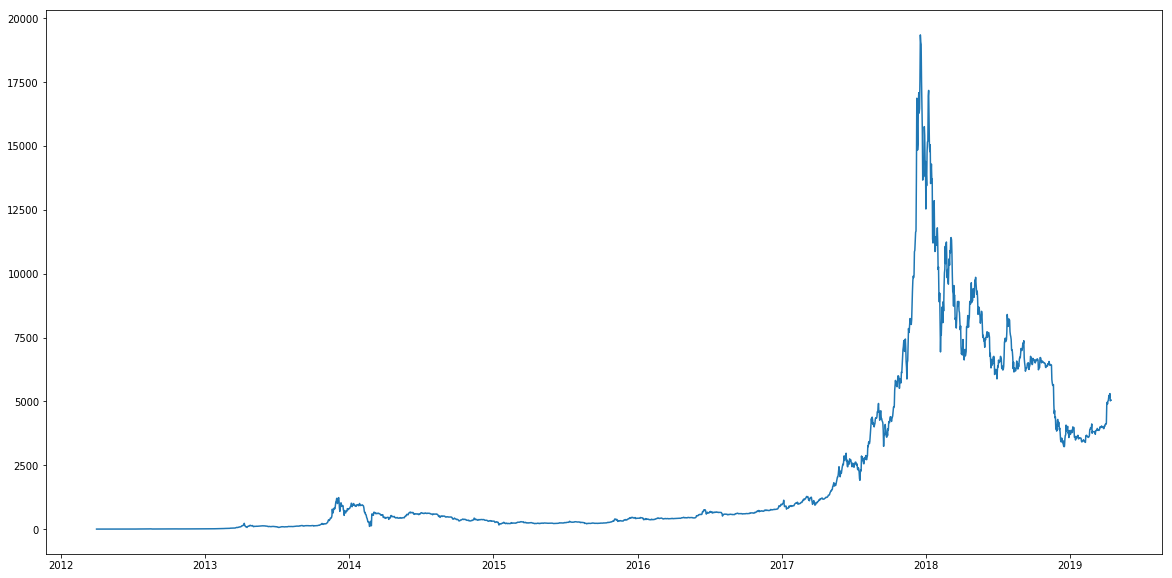

In [33]:
#plot
plt.plot(df[['Open']], label='Open Price history')

In [34]:
import statsmodels.api as sm
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

s = sm.tsa.seasonal_decompose(np.flip(df['Open'].values), freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

In [35]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)

#splitting into train and validation
dev_size = 300
train = data[:-dev_size]
dev = data[-dev_size:]

data.shape, train.shape, dev.shape

((2570, 7), (2270, 7), (300, 7))

In [37]:
#Moving Average
preds = []
for i in range(0,dev_size):
    a = train['Open'][len(train)-dev_size+i:].sum() + dev['Open'][:i].sum()
    b = a/dev_size
    preds.append(b)
    
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev['Open'])-preds),2)))
rms

2408.2555459952077

/anaconda3/envs/cs230/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



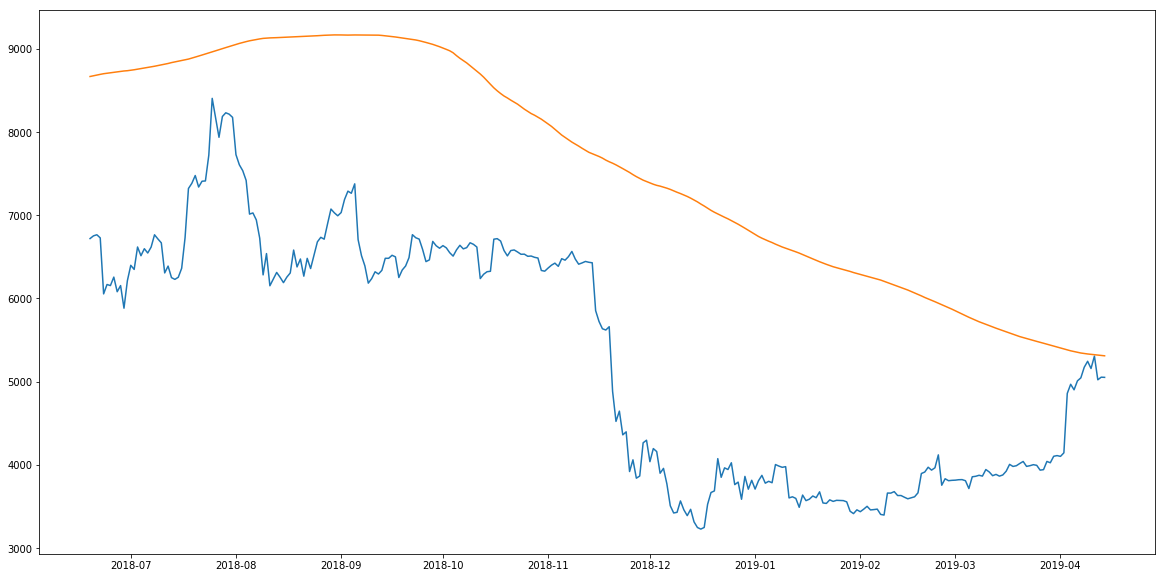

In [40]:
#plot
dev['Moving Average'] = preds
# plt.plot(train['Open'])
plt.plot(dev[['Open', 'Moving Average']])

In [41]:
from statsmodels.tsa.arima_model import ARIMA

train_list, test_list = np.asarray(train['Open']), np.asarray(dev['Open'])
history = [x for x in train_list]

predictions = []
for t in range(len(test_list)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)

#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev['Open'])-predictions),2)))
print('ARIMA RMSE: %.3f' % rms)

/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA RMSE: 2055.586


/anaconda3/envs/cs230/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



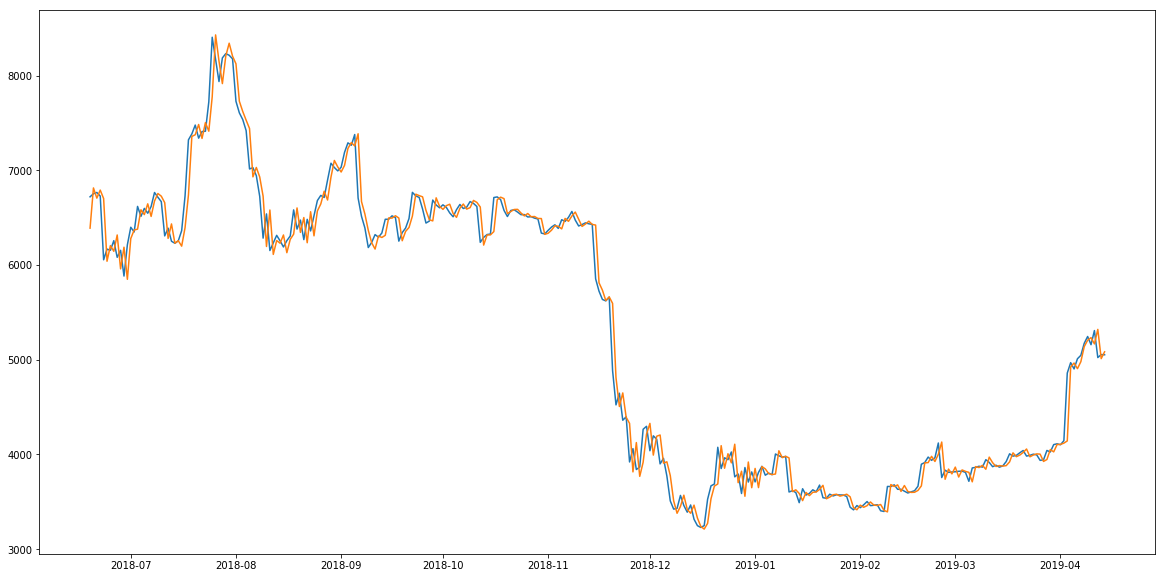

In [42]:
dev['ARIMA'] =predictions
# plt.plot(train['Open'])
plt.plot(dev[['Open', 'ARIMA']])

In [43]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR

history = train.copy()
predictions = []
for t in range(len(dev)):
    model = VAR(endog=np.asarray(history[['Price', 'Open', 'High', 'Low', 'Vol.', "Change %"]]))
    model_fit = model.fit()
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0][0]
    predictions.append(yhat)
    obs = dev[['Price', 'Open', 'High', 'Low', 'Vol.', "Change %"]].iloc[[t]]
    history = history.append(obs)
    

#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev['Open'])-predictions),2)))
print('RMSE: %.3f' % rms)

RMSE: 23.815


/anaconda3/envs/cs230/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



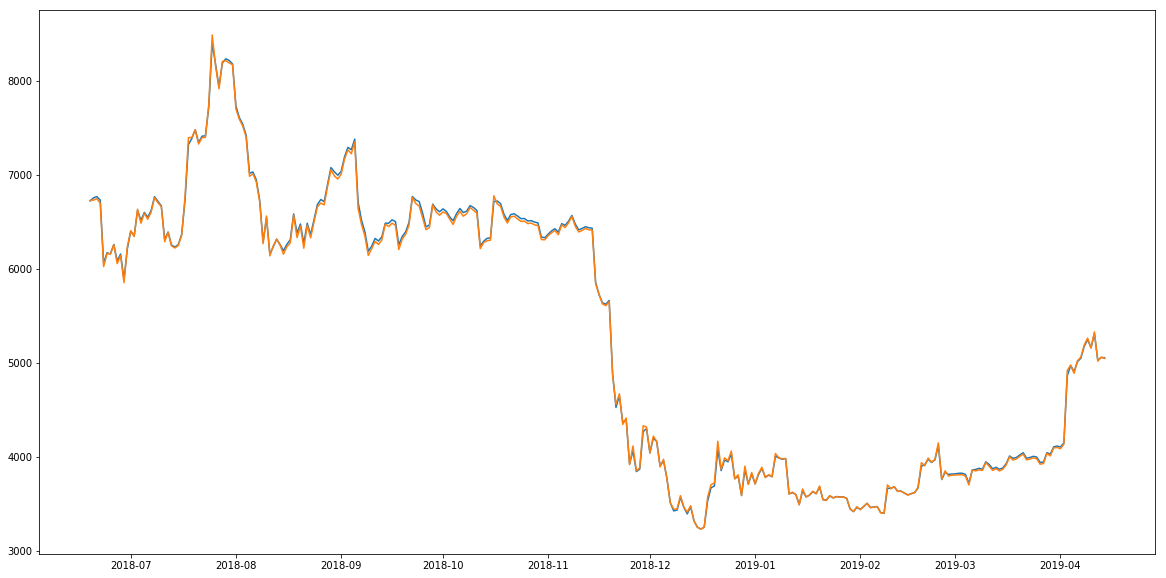

In [44]:
#plot
dev['VAR'] = predictions
# plt.plot(train['Open'])
plt.plot(dev[['Open', 'VAR']])